# Analiza popularności gatunków muzycznych na spotify

## Autorzy:
- Oskar Rozwadowski 311400
- Piotr Klepacki 311300

# Analiza eksploracyjna danych

Wczytanie potrzebnych nam bibliotek

In [462]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.linear_model import LassoCV
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math 
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

Wczytanie pliku i wstępne badanie struktury danych

In [463]:
data = pd.read_csv('data_by_genres.csv')
print(data.info())
print(data.shape)
print(data.keys())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            2664 non-null   object 
 1   acousticness      2664 non-null   float64
 2   danceability      2664 non-null   float64
 3   duration_ms       2664 non-null   float64
 4   energy            2664 non-null   float64
 5   instrumentalness  2664 non-null   float64
 6   liveness          2664 non-null   float64
 7   loudness          2664 non-null   float64
 8   speechiness       2664 non-null   float64
 9   tempo             2664 non-null   float64
 10  valence           2664 non-null   float64
 11  popularity        2664 non-null   float64
 12  key               2664 non-null   int64  
 13  mode              2664 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 291.5+ KB
None
(2664, 14)
Index(['genres', 'acousticness', 'danceability', 'duration_m

Nasze dane składają się z 2664 gatunków, zawierających 14 opisujących je cech.Zgodnie z informacjami zawartymi w źródle danych te cechy to:
- Genre: Gatunek utworu
- Acousticness: Pewność, że dany utwór jest akustyczny w skali od 0.0 do 1.0
- Danceability: Skala przydatności utworu do tańca w skali od 0.0 do 1.0
- Duration_ms: Długość utworu w milisekundach
- Energy: Percepcyjna skala intensywności i aktywności utworu, zawiera wartości od 0.0 do 1.0
- Instrumentalness: Pewność, że dany utwór nie zawiera słów w skali od 0.0 do 1.0
- Key: Wysokość dźwięku zmapowana na liczby całkowite w skali od 0 do 11
- Liveness: Pewność, że dane nagranie pochodzi z koncertu w skali od 0.0 do 1.0
- Loudness: Głośność utworu w decybelach
- Mode: Modalność utworu, 1 oznacza skale majorową, 0 skale minorową
- Popularity: Popularność utworu w skali od 0 do 100
- Speechiness: Stopień użycia słów w utworze, przeważnie muzyka przyjmuje wartosć poniżej 0.33, utwory z mieszanką muzyki i słów od 0.33 do 0.66, utwory nie zawierające muzyki od 0.66 do 1.0
- Tempo: Tempo w BPM
- Valence: Skala określająca "pozytywność" utworu, przyjmuje watości od 0.0 do 1.0

Poniżej zajmiemy się czyszczeniem danych.

In [464]:
print('Czy dane zawierają braki = ' , data.isnull().values.any())
print('Czy gatunki są unikalne = ' , not data['genres'].duplicated().any())
data = data.drop('genres', axis=1)

Czy dane zawierają braki =  False
Czy gatunki są unikalne =  True


Gatunki są unikalne więc możemy je odrzucić w dalszej analizie.

In [465]:
data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
count,2664.000000,2664.000000,2.664000e+03,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000
mean,0.399060,0.536555,2.493834e+05,0.564704,0.200024,0.193866,-10.376636,0.083746,118.848316,0.499293,40.119079,5.915541,0.843093
std,0.313948,0.148557,9.056834e+04,0.227515,0.256310,0.088000,4.994773,0.080169,17.525562,0.197600,16.018515,3.390251,0.363781
min,0.000003,0.059851,3.094600e+04,0.002825,0.000000,0.022200,-37.613463,0.022502,37.764836,0.004886,0.000000,0.000000,0.000000
25%,0.120052,0.445851,2.054136e+05,0.403441,0.005402,0.144772,-12.387067,0.045427,109.294764,0.362073,33.000000,3.000000,1.000000
50%,0.319612,0.544778,2.370955e+05,0.600476,0.077899,0.180000,-9.288375,0.060379,118.747590,0.508720,43.000000,7.000000,1.000000
75%,0.657829,0.643117,2.723142e+05,0.733009,0.320169,0.220329,-6.945217,0.090329,127.203333,0.638521,50.879969,9.000000,1.000000
max,0.996000,0.957333,1.644773e+06,0.999500,0.992000,0.927000,-0.131500,0.940935,210.095000,0.980000,82.000000,11.000000,1.000000


- Instrumentalness i popularity są jedynymi cechami proporcjonalnymi, w których występują gatunki osiągające minimalną możliwą dla nich wartość.
- Wartości liveness przeważnie obierają wartości poniżej 0.22

Cechy na zakresie <0;1>
- Acousticness przyjmuje zazwyczaj niskie wartości. Dla połowy obserwacji wartość wynosi poniżej 0.32
- Większość genre cechuje się danceability z przedziału <0.44 ; 0.65>
- Większość genre ma energy powyżej 0.6. Jedynie 25% obserwacji ma poniżej 0.4
- Zdecydowana większośc obserwacji ma niską instrumentalness. Mediana ma wartość 0.078
- Liveness również przyjmuje przeważnie niskie wartości. Trzeci kwartyl to 0.22
- Wartości speechiness skoncentrowane są jeszcze niżej, większość osiąga wartość mniejszą niż 0.1
- Valence jest stosunkowo równo zdystrybuowana na całym zakresie


Pozostałe cechy
- Większość genre charakteryzuje się długością utworów pomiędzy 205 i 272 sekund
- Większość genre ma loudness poniżej -9 dB
- Najczęsciej występują tempa w zakresie od 109 do 127 BPM
- 84% genre posiada mode major
- Instrumentalness i popularity są jedynymi cechami proporcjonalnymi spoza zakresu <1;0>, w których występują gatunki osiągające minimalną możliwą dla nich wartość.

Popularność
- Wartości w zakresie od 0 do 82
- Średnia wartość to 40 ze standardowym odchyleniem 16
- Większość wartości w przedziale od 33 do 51

<AxesSubplot:>

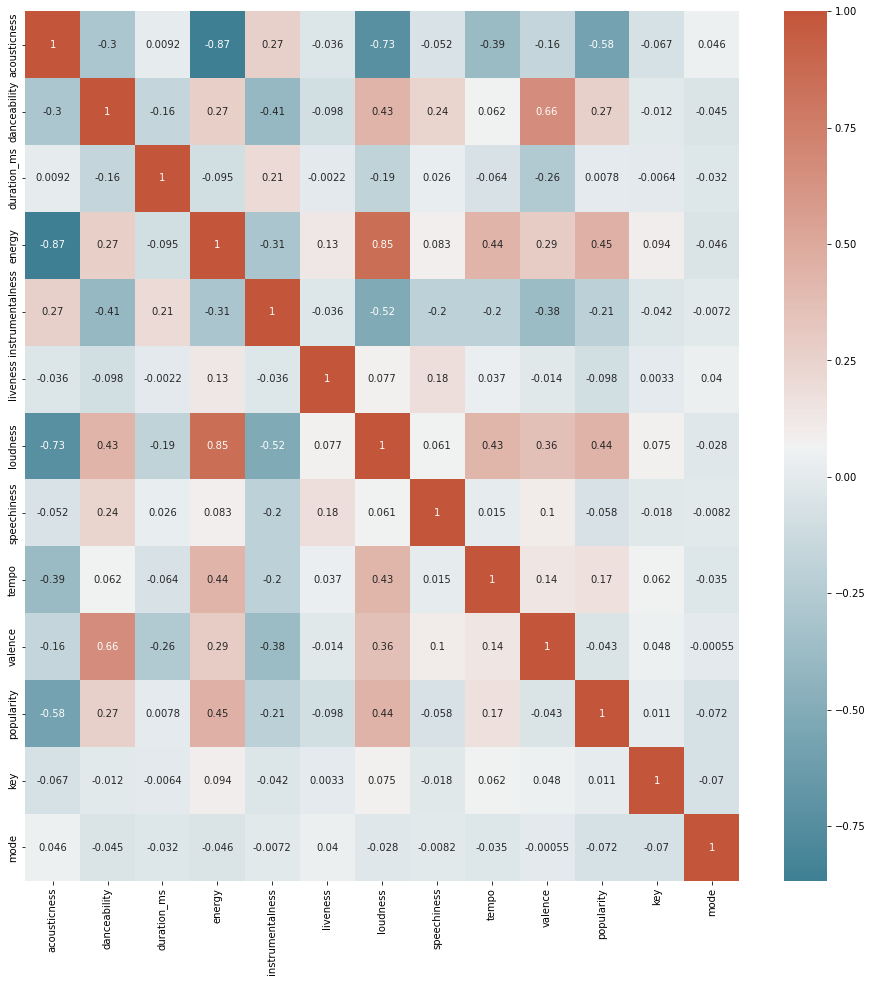

In [466]:
corr = data.corr()
plt.figure(figsize = (16,16))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Jak widać energy jest mocno skorelowane z loudness i negatywnie skorelowane z acousticness, co widać również w korelacji negatywnej acousticness z loudness. Nie jest to dziwne biorąc pod uwagę, że gatunki głośne są bardzo często również energiczne i używają mniej (lub wcale) instrumentów akustycznych. Ciekawa jest również korelacja pomiędzy wymienionymi wyżej cechami i popularnością. Muzyka akustyczna jest znacznie mniej popularna, niż muzyka głośna i energiczna. Korelacje cech key oraz duration_ms są bliskie zeru i można przypuszczać, że nie będą przydatne przy analizie regresji.

[Text(0.5, 0, 'energy'), Text(0, 0.5, 'loudness')]

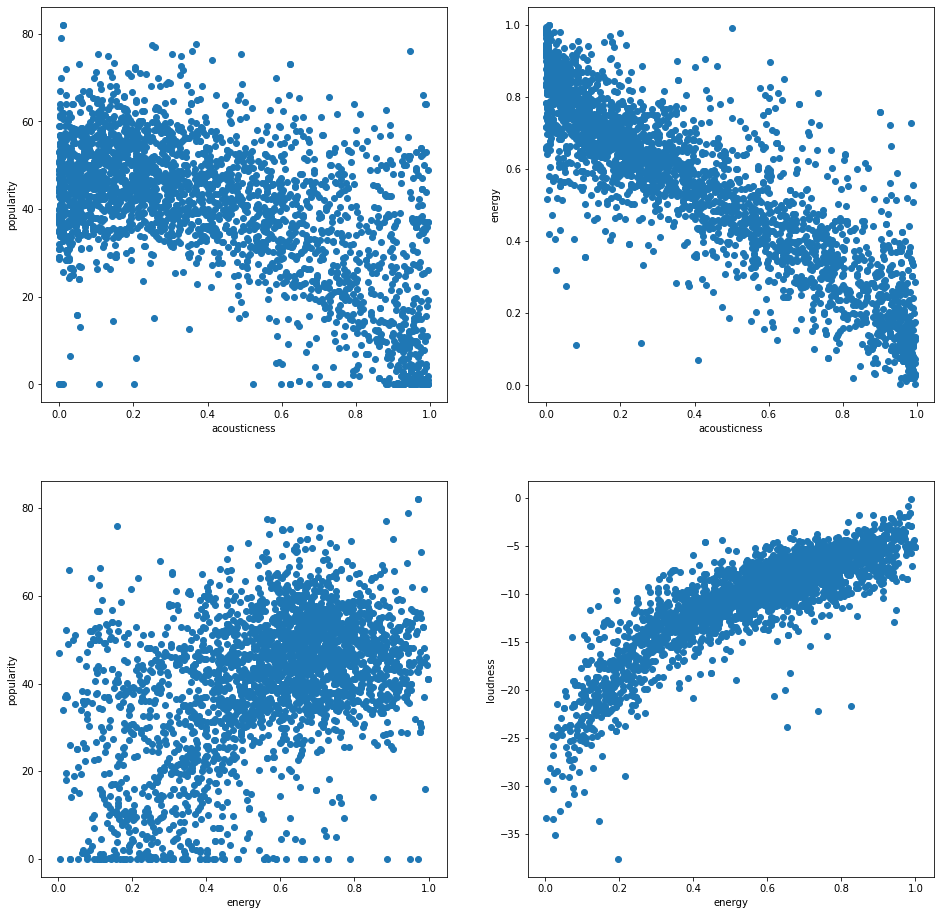

In [467]:
fig, ax = plt.subplots(2,2, figsize = (16,16))
ax[0,0].scatter(data['acousticness'], data['popularity'])
ax[0,0].set(xlabel='acousticness', ylabel='popularity')

ax[0,1].scatter(data['acousticness'], data['energy'])
ax[0,1].set(xlabel='acousticness', ylabel='energy')

ax[1,0].scatter(data['energy'], data['popularity'])
ax[1,0].set(xlabel='energy', ylabel='popularity')

ax[1,1].scatter(data['energy'], data['loudness'])
ax[1,1].set(xlabel='energy', ylabel='loudness')


Powyższe wykresy jedynie potwierdzają wcześniejsze wnioski, ale pozwalają na łatwiejsze zobrazowanie relacji pomiędzy cechami. Posiadanie 3 silnie skorelowanych ze sobą cech, wskazuje na to, że możliwe jest pozbycie się jednej z nich (prawdopodobnie loudness przez najniższą korelację z popularity) w etapie budowania modelu regresji liniowej.

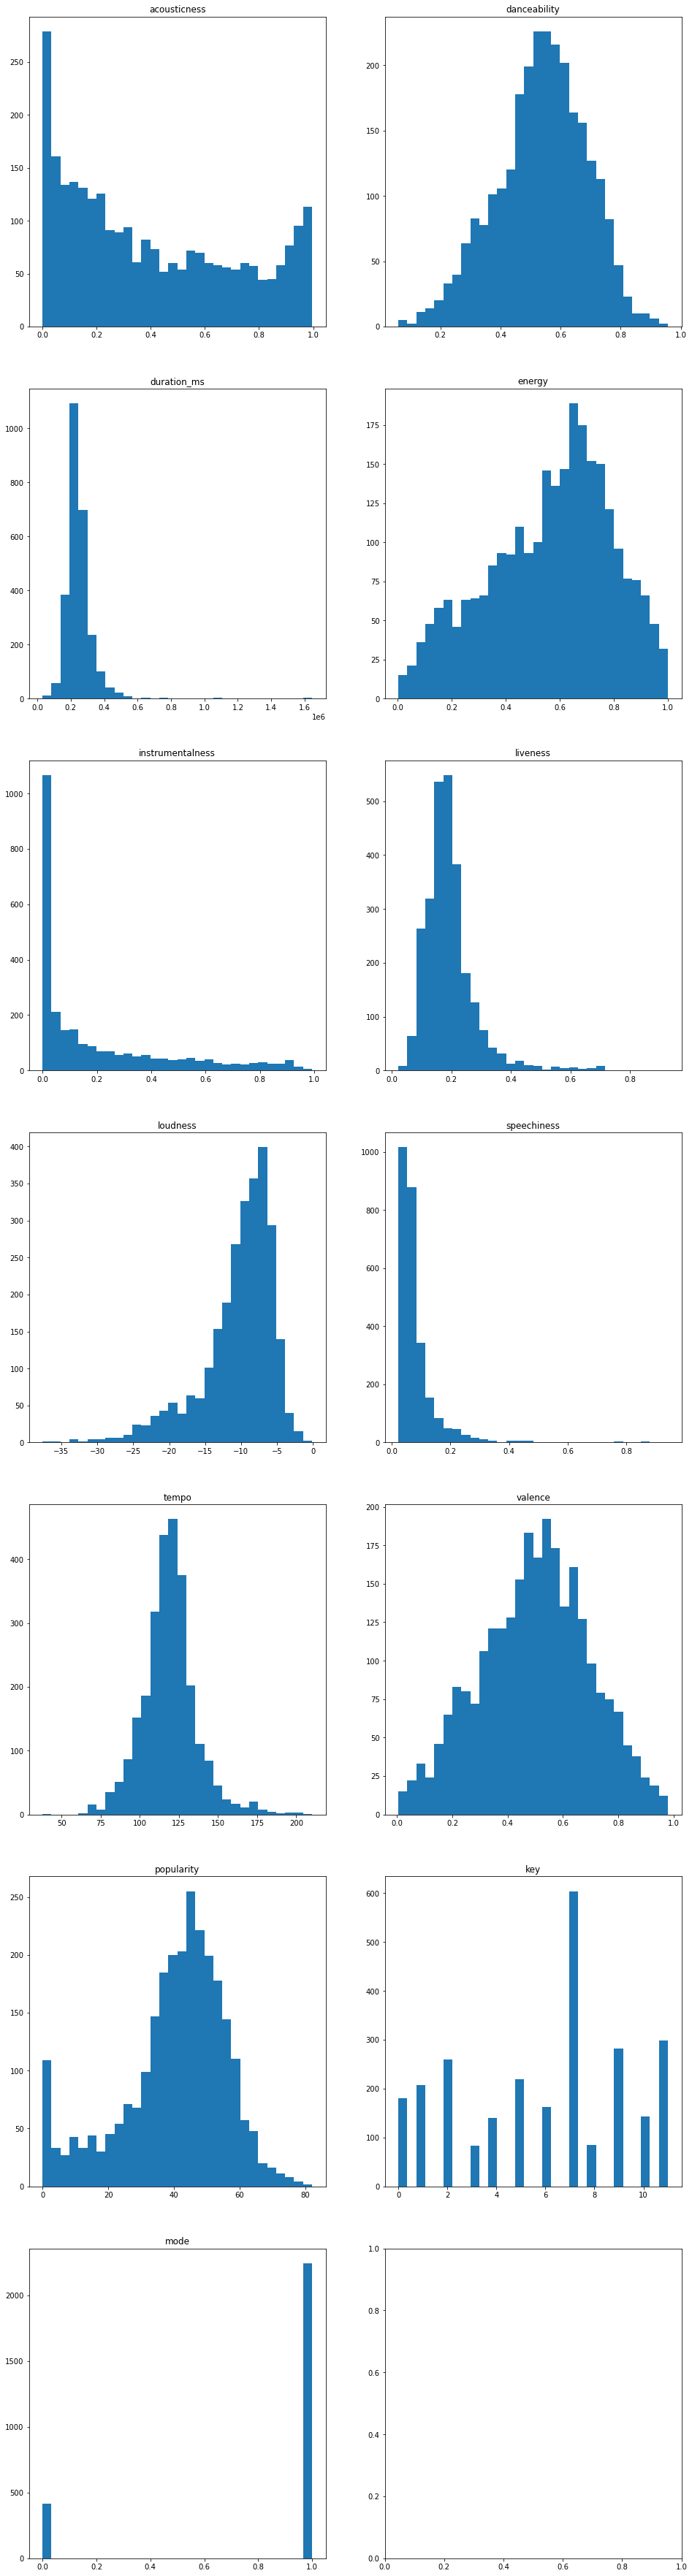

In [468]:
fig, ax = plt.subplots(7,2, figsize = (16,64))

columns = list(data.columns)
c = 0

for i in range(7):
    for j in range(2):
        ax[i,j].hist(data[columns[c]], bins = 30)
        ax[i,j].set_title(columns[c])
        c = c + 1
        if(c == 13):break



W celu dokładniejszej analizy popularności, stworzymy zmienną pop2,
przyjmie ona wartość 0 dla 33% najmniej popularnych genre, 1 dla następnych 33% oraz 2 dla najpopularniejszych obserwacji.

In [469]:
#print(data['popularity'].quantile([.3333, .6667]))
data['pop2'] = np.where(data['popularity'] <= 36.819331, 0, 1)
data['pop2'] = np.where(data['popularity'] <= 48, data['pop2'], 2)
#data.head()

In [470]:
means = pd.DataFrame()
means['Feature'] = list(data.columns)
means['pop2 = 0'] = data.loc[data['pop2'] == 0].mean().values
means['pop2 = 1'] = data.loc[data['pop2'] == 1].mean().values
means['pop2 = 2'] = data.loc[data['pop2'] == 2].mean().values
means

,Feature,pop2 = 0,pop2 = 1,pop2 = 2
0,acousticness,0.623051,0.311180,0.262566
1,danceability,0.498032,0.524012,0.588126
2,duration_ms,245423.087667,262837.307671,239707.539388
3,energy,0.433749,0.617297,0.643270
4,instrumentalness,0.257999,0.205365,0.136162
5,liveness,0.202723,0.193759,0.185046
6,loudness,-13.169656,-9.750337,-8.197674
7,speechiness,0.087625,0.080162,0.083478
8,tempo,115.324802,120.241233,120.984774
9,valence,0.523842,0.493010,0.480930


Porównując średnie wartości każdej cechy możemy wysunąć wstępne przypuszczenia dotyczące ich wpływu na popularność gatunku.<br>
Duration, speechiness, liveness, tempo, valence, key oraz mode nie wykazują wyraźnych różnic pomiędzy badanymi grupami.<br>
Najmniej popularne gatunki są zdecydowanie bardziej akustyczne i mniej energetyczne od pozostałych.<br>
Danceability oraz loudness rośnie, zaś instrumentalness maleje wraz ze wzrostem popularności.<br>


Analiza stopnia wypełnienia

In [471]:
columns = list(data.columns)

for c in columns:  
    column = data[c]
    count = (column == 0).sum()
    print(f"{c} - {count} of zero values")

acousticness - 0 of zero values
danceability - 0 of zero values
duration_ms - 0 of zero values
energy - 0 of zero values
instrumentalness - 123 of zero values
liveness - 0 of zero values
loudness - 0 of zero values
speechiness - 0 of zero values
tempo - 0 of zero values
valence - 0 of zero values
popularity - 64 of zero values
key - 181 of zero values
mode - 418 of zero values
pop2 - 888 of zero values


Wartości zerowe w kolumnie instrumentalność są nieporządane. Obserwacje o takich wartościach zostaną usunięte.
Popularność również nie powinna zawierać bardzo niskich wartości. Wartości poniżej 5 dotyczą bardzo niszowych genre, których uwzględnienie mogłoby jedynie utrudnić wyłonienie cech maksymalizujących popularność utworu. Takie obserwacje również zostaną zatem usunięte.

In [472]:
data.drop(data[data.instrumentalness < 0.01].index, inplace=True)
data.drop(data[data.popularity < 0.01].index, inplace=True)
for c in columns:  
    column = data[c]
    count = (column == 0).sum()
    print(f"{c} - {count} of zero values")
col_list = list(data.columns)
col_list[0], col_list[10] = col_list[10], col_list[0]
data = data[col_list]
data.info()    

acousticness - 0 of zero values
danceability - 0 of zero values
duration_ms - 0 of zero values
energy - 0 of zero values
instrumentalness - 0 of zero values
liveness - 0 of zero values
loudness - 0 of zero values
speechiness - 0 of zero values
tempo - 0 of zero values
valence - 0 of zero values
popularity - 0 of zero values
key - 126 of zero values
mode - 259 of zero values
pop2 - 662 of zero values
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1862 entries, 0 to 2663
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        1862 non-null   float64
 1   danceability      1862 non-null   float64
 2   duration_ms       1862 non-null   float64
 3   energy            1862 non-null   float64
 4   instrumentalness  1862 non-null   float64
 5   liveness          1862 non-null   float64
 6   loudness          1862 non-null   float64
 7   speechiness       1862 non-null   float64
 8   tempo          

Ostatecznie otrzymaliśmy zbiór danych zawierający 1862 obserwacji, który posłuży nam do budowania modelu regresji liniowej.

Na podstawie opracowanej analizy wyznaczono hipotezę badawczą: <br>
Popularność utworu jest przede wszyskim zależna od poniższych cech:
- odwrotnie proporcjonalna do akustyczności i instrumentalności
- proporcjonalna do energetyczności i taneczności

# Modele regresji

## Podział na zbiory uczące i testowe

In [473]:
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,1:-1], data["popularity"], test_size=0.2, random_state=42)
columns = list(x_train.columns)

## Proste modele liniowe

Na początek przeprowadzono proste modele regresji wielomianowej dla każdego z czterech rozważanych atrybutów.

In [474]:
def poly_co(xs, coeffs):
    order = len(coeffs)
    ys = np.zeros(len(xs))
    for i in range(order):
        ys += coeffs[i] * xs ** i
    return ys

In [475]:
def pr(c,n):
    xs = np.linspace(data[c].min(), data[c].max(), 100)
    err = np.zeros(n)
    plt.figure(figsize=(10, 6))
    plt.title(f"Polynomial regression of {c} for the selected polynomial degrees", size=16)
    plt.scatter(x_test[c].values.reshape(-1, 1), y_test, c = "plum")
    for i in range(1,n+1):
        poly = PolynomialFeatures(degree=i, include_bias=False)
        poly_features = poly.fit_transform(x_train[c].values.reshape(-1, 1))
        poly_reg_model = LinearRegression()
        poly_reg_model.fit(poly_features, y_train)
        print(f"Polynomial degree: {i}")
        print(f"R^2 = {poly_reg_model.score(poly_features, y_train)}")
        print(f"intercept = {poly_reg_model.intercept_}")
        print(f"coefficients = {poly_reg_model.coef_}\n")
        poly_features = poly.fit_transform(x_test[c].values.reshape(-1, 1))
        err[i-1] = metrics.mean_squared_error(y_test, poly_reg_model.predict(poly_features))
        plt.plot(xs,poly_co(xs,np.concatenate((np.array([poly_reg_model.intercept_]),poly_reg_model.coef_))),label=str(i))
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.title(f"The mean squared error of the curve fit", size=16)
    plt.plot(range(1,6),err)
    plt.show()

In [476]:
def pr2(c,n):
    for i in range(1,n+1):
        x = x_train.join(y_train)
        x = sm.add_constant(x)
        form = f'popularity ~ {c}'
        for j in range(2,i+1):
            form += f" + I({c}**{j})"
        model = smf.ols(formula = form, data = x).fit()
        print(model.summary())

### Acousticness

Polynomial degree: 1
R^2 = 0.3017294862667843
intercept = 49.661540395711086
coefficients = [-24.94254499]

Polynomial degree: 2
R^2 = 0.3414521460487304
intercept = 45.53027858432204
coefficients = [  9.00136737 -36.06535494]

Polynomial degree: 3
R^2 = 0.35342245074625467
intercept = 43.20400648612392
coefficients = [  48.2681109  -146.47646039   77.49587178]

Polynomial degree: 4
R^2 = 0.35408118352372087
intercept = 43.74029552763751
coefficients = [ 32.14743341 -61.64476486 -65.18473257  74.57015075]

Polynomial degree: 5
R^2 = 0.3546857895772657
intercept = 43.244421405797034
coefficients = [  55.73828123 -257.10105388  505.95605877 -605.73748958  282.84621593]



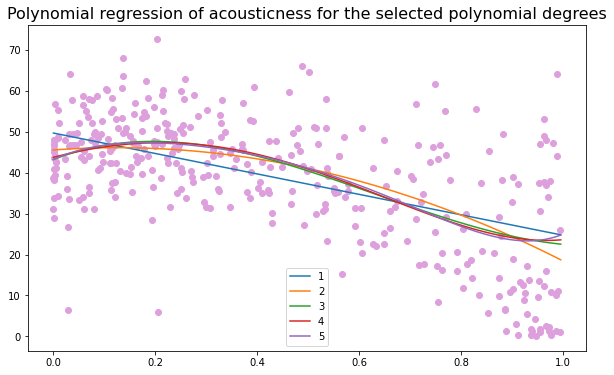

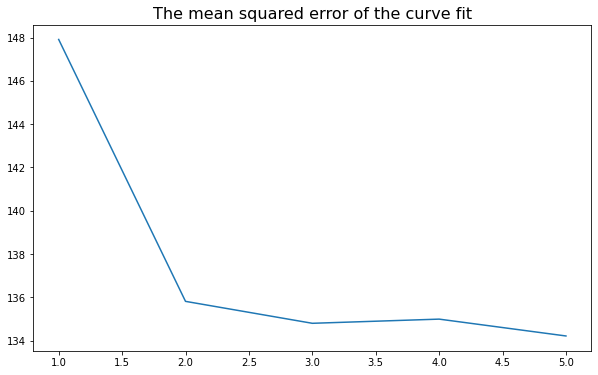

In [477]:
pr("acousticness",5)

### Instrumentalness

Polynomial degree: 1
R^2 = 0.02191282440129283
intercept = 41.903255995692135
coefficients = [-8.17836589]

Polynomial degree: 2
R^2 = 0.07531401731561427
intercept = 46.010686976286664
coefficients = [-50.30050292  52.13090768]

Polynomial degree: 3
R^2 = 0.07575462401027255
intercept = 45.56593603321643
coefficients = [-41.87775856  25.85874028  20.19570642]

Polynomial degree: 4
R^2 = 0.07587735654799654
intercept = 45.832417042281875
coefficients = [-49.61634412  69.49560945 -59.507605    45.14150757]

Polynomial degree: 5
R^2 = 0.07701537506486422
intercept = 46.79368847357927
coefficients = [  -87.78081345   394.84410678 -1062.61982474  1312.95646907
  -559.87252599]



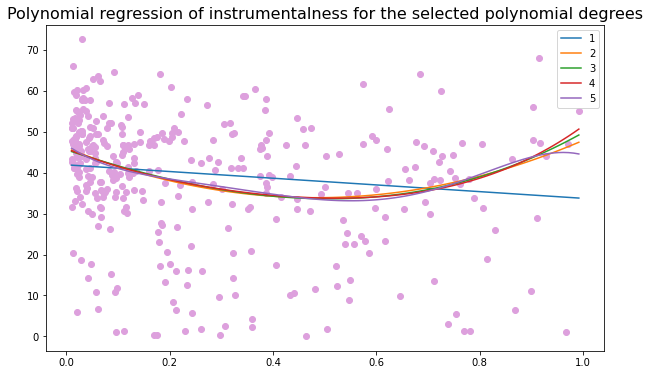

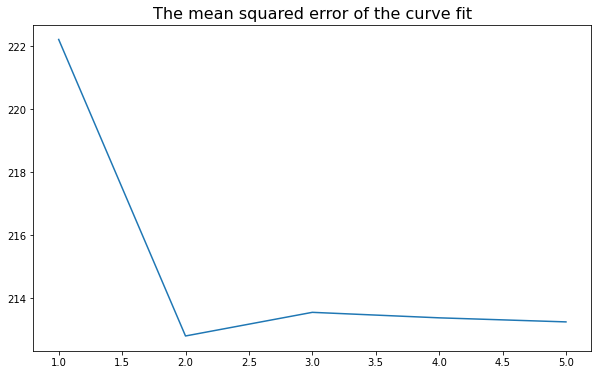

In [478]:
pr("instrumentalness",5)

### Energy

Polynomial degree: 1
R^2 = 0.19531380524984943
intercept = 24.15436805993473
coefficients = [27.91089326]

Polynomial degree: 2
R^2 = 0.19714837361533044
intercept = 21.875439154392197
coefficients = [ 39.16464341 -10.99411004]

Polynomial degree: 3
R^2 = 0.2441603509338106
intercept = 39.091976929206076
coefficients = [-116.66806773  340.84211485 -226.75145225]

Polynomial degree: 4
R^2 = 0.25399887278946265
intercept = 49.99857875817367
coefficients = [ -268.69423116   933.1765374  -1089.0773894    418.78628314]

Polynomial degree: 5
R^2 = 0.25641058465172606
intercept = 43.23988773088963
coefficients = [ -134.78186217   142.48141943   845.46728442 -1661.11795579
   813.40772309]



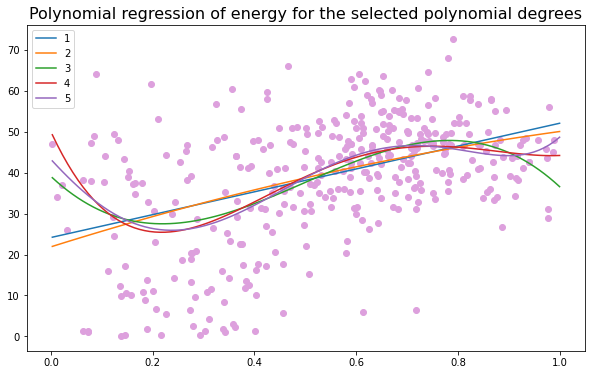

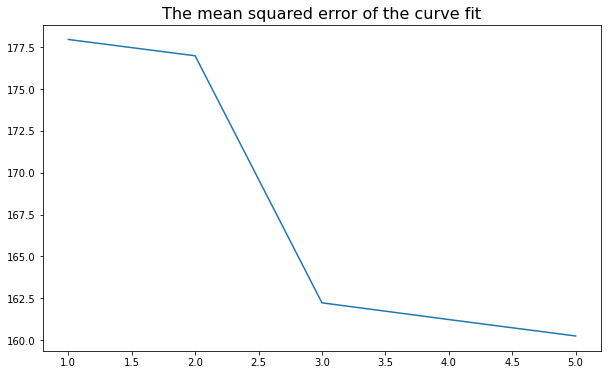

In [479]:
pr("energy",5)

### Danceability

Polynomial degree: 1
R^2 = 0.05334946690627729
intercept = 27.803017845053496
coefficients = [22.85923927]

Polynomial degree: 2
R^2 = 0.06992099004237828
intercept = 43.02198240841387
coefficients = [-44.81287721  68.44471116]

Polynomial degree: 3
R^2 = 0.08177239633761224
intercept = 68.63238893602113
coefficients = [-233.72434351  483.77017122 -280.7205817 ]

Polynomial degree: 4
R^2 = 0.08229478601476037
intercept = 59.464327132485316
coefficients = [-135.53793808  133.70082047  226.57004023 -256.9599505 ]

Polynomial degree: 5
R^2 = 0.08549330389889997
intercept = 99.0879967164546
coefficients = [ -712.38674889  3085.35873586 -6614.53840972  7076.3112121
 -2950.94633561]



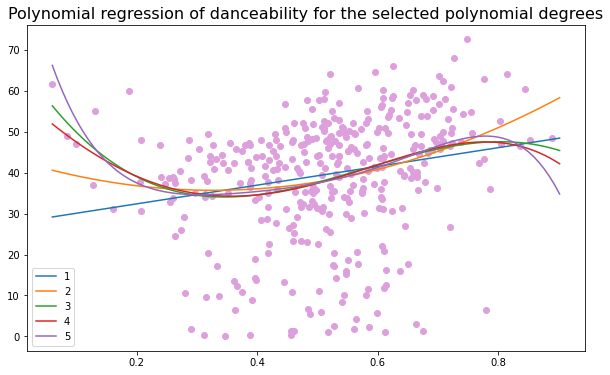

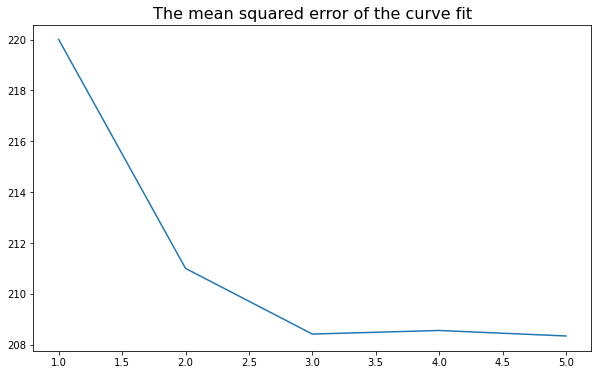

In [480]:
pr("danceability",5)

## Regresja wieloraka

Następnie spróbowano stworzyć model wykorzystujący wszystkie cechy opisujące.

In [481]:
columns = list(x_train.columns)

In [482]:
def mr2(c,n):
    x = x_train.join(y_train)
    x = sm.add_constant(x)
    form = f'popularity ~ '
    for j in range(1,n+1):
        for name in c:
            form += f" + I({name}**{j})"
    model = smf.ols(formula = form, data = x).fit()
    print(model.summary())

In [483]:
mr2(columns,1)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     100.4
Date:                Mon, 23 Jan 2023   Prob (F-statistic):          1.58e-181
Time:                        00:57:17   Log-Likelihood:                -5652.8
No. Observations:                1489   AIC:                         1.133e+04
Df Residuals:                    1476   BIC:                         1.140e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Tym razem pominięto zmienne, które okazały się zbędne w poprzednim modelu.

In [486]:
columns2 = ['danceability',
 'instrumentalness',
 'liveness',
 'speechiness',
 'valence',
 'acousticness',
 'mode']

In [487]:
mr2(columns2,1)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     170.3
Date:                Mon, 23 Jan 2023   Prob (F-statistic):          7.33e-185
Time:                        00:59:04   Log-Likelihood:                -5657.6
No. Observations:                1489   AIC:                         1.133e+04
Df Residuals:                    1481   BIC:                         1.137e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Następnie dodano kwadraty wybranych cech.

In [488]:
mr2(columns2,2)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     134.6
Date:                Mon, 23 Jan 2023   Prob (F-statistic):          2.22e-239
Time:                        00:59:40   Log-Likelihood:                -5514.9
No. Observations:                1489   AIC:                         1.106e+04
Df Residuals:                    1475   BIC:                         1.113e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Na podstawie otrzymanych modeli i eksperymentów z mnożeniem cech przez siebie otrzymano poniższy model.

In [489]:
def mr3(f):
    x = x_train.join(y_train)
    x = sm.add_constant(x)
    model = smf.ols(formula = f, data = x).fit()
    print(model.summary())

In [502]:
form = 'popularity ~ instrumentalness + liveness + speechiness + valence + acousticness + mode + I(danceability**2) + I(instrumentalness**2) + I(liveness**2) + I(acousticness**2)  + I(energy ** 3) + I(acousticness*loudness)'
form

'popularity ~ instrumentalness + liveness + speechiness + valence + acousticness + mode + I(danceability**2) + I(instrumentalness**2) + I(liveness**2) + I(acousticness**2)  + I(energy ** 3) + I(acousticness*loudness)'

In [503]:
mr3(form)

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     157.0
Date:                Mon, 23 Jan 2023   Prob (F-statistic):          2.29e-253
Time:                        08:59:32   Log-Likelihood:                -5484.8
No. Observations:                1489   AIC:                         1.100e+04
Df Residuals:                    1476   BIC:                         1.106e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Zgodnie z tym modelem, popularność utworów zależy głównie od: instrumentalness, liveness, speechiness, valence, acousticness , mode, danceability, energy oraz loudness.
Wiele z tych cech nie wydawało się szczególnie istotne po analizie eksploracyjnej.

## Standaryzacja

In [447]:
columns = list(data.columns)
columns.remove('popularity')
columns.remove('mode')
sc = StandardScaler()
data_scaled = sc.fit_transform(data[columns])
data_scaled = pd.DataFrame(data = data_scaled, columns = columns)


x_train, x_test, y_train, y_test = train_test_split(data_scaled[columns], data['popularity'],
                                                    test_size=0.2, random_state=42)

## Regresja metodą Lasso

In [448]:
space_lasso = np.linspace(0,1, 100)
params_lasso = {'alpha': space_lasso}

modelLasso = linear_model.Lasso()
clfLasso = GridSearchCV(modelLasso, params_lasso)
clfLasso.fit(x_train, y_train)

print('Wartość alpha z najlepszym wynikiem:', clfLasso.best_params_)
y_pred_lasso = clfLasso.predict(x_train)
err_lasso = metrics.mean_squared_error(y_train, y_pred_lasso)
print('RMSE uczenia dla regularyzacji lasso i najlepszego alpha:',err_lasso)
y_pred_lasso = clfLasso.predict(x_test)
err_lasso = metrics.mean_squared_error(y_test, y_pred_lasso)
print('RMSE generalizacji dla regularyzacji lasso i najlepszego alpha:',err_lasso)


Wartość alpha z najlepszym wynikiem: {'alpha': 0.06060606060606061}
RMSE uczenia dla regularyzacji lasso i najlepszego alpha: 117.20945533428265
RMSE generalizacji dla regularyzacji lasso i najlepszego alpha: 128.1291184133885


Podczas wcześniej przeprowadzonych testów, okazało się że przeszukiwanie przestrzeni alpha powyżej wartości 1 jest bezcelowe, jako że daje nam to gorsze wyniki i mniejszą dokładność w przeszukiwaniu przestrzeni od 0 do 1. Wartość alpha wybrana przez GridSearchCV jest stosunkowo mała. Błąd uczenia jest bliski błędu generalizacji, co oznacza że jej wysoka wartość nie jest spowodowana zbytnim dopasowaniem do danych. 

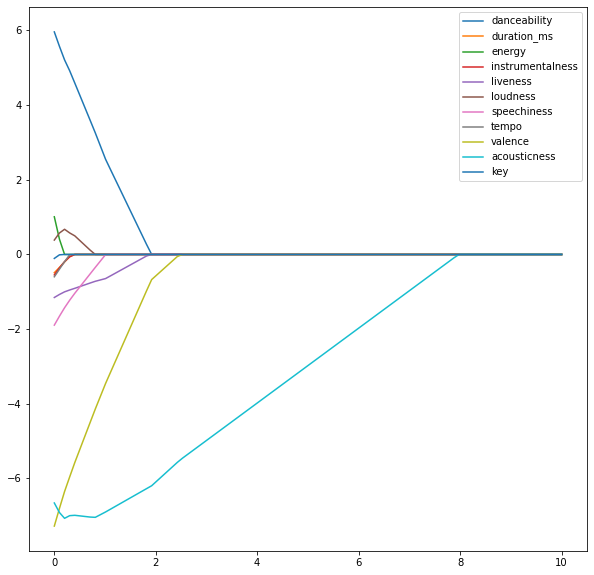

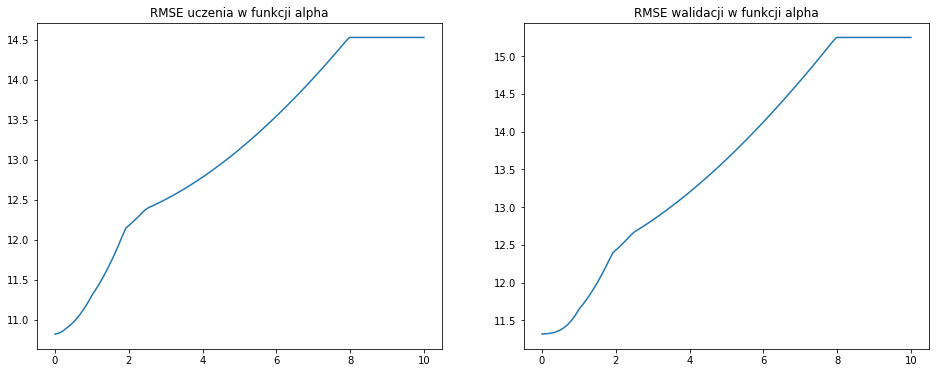

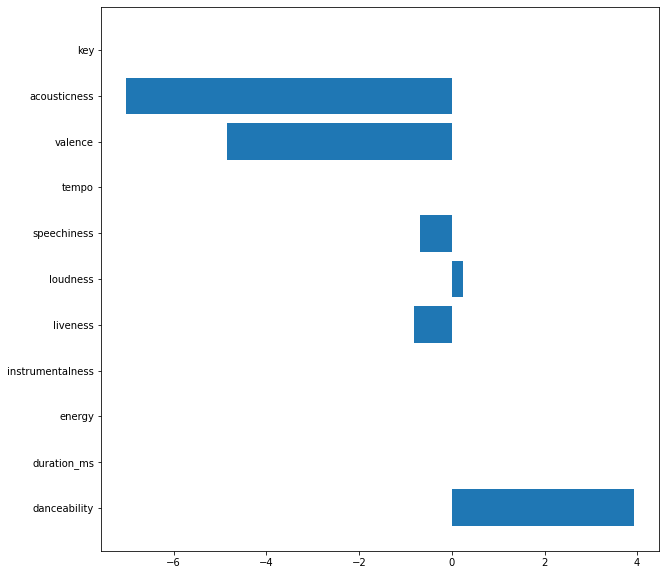

In [449]:
rmse_array_train = [None] * 100
rmse_array_test = [None] * 100

coef = [[0] * 11] * 100

alpha_array = np.linspace(0, 10, 100)

count = 0
for i in alpha_array:
    model_all = linear_model.Lasso(alpha=i, normalize=False) # set parameters
    model_all.fit(x_train, y_train) # learn weights
    coef[count] = model_all.coef_
    y_pred = model_all.predict(x_train)                    
    mse = metrics.mean_squared_error(y_pred, y_train)
    rmse = math.sqrt(mse)
    rmse_array_train[count] = rmse
    
    y_pred = model_all.predict(x_test)                    
    mse = metrics.mean_squared_error(y_pred, y_test)
    rmse = math.sqrt(mse)
    rmse_array_test[count] = rmse
    
    count = count + 1
      
plt.figure(figsize = (10,10))
        
plt.plot(alpha_array, coef)
plt.legend(columns)
plt.show()    

fig, ax = plt.subplots(1,2, figsize = (16,6))


ax[0].plot(alpha_array, rmse_array_train)
ax[0].set_title("RMSE uczenia w funkcji alpha")

ax[1].plot(alpha_array, rmse_array_test)
ax[1].set_title("RMSE walidacji w funkcji alpha")

plt.figure(figsize = (10,10))
plt.barh(columns,coef[6])
plt.show()


Wynik zerowanie cech przy pomocy metody Lasso nie pokrywa się całkowicie z hipotezą wysuniętą na etapie eksploracji danych. W tym przypadku instrumentalness i energy okazały się nieistotne, a cechami ważniejszymi okazały się speechiness, loudness oraz liveness. W okolicach alpha = 1 pozostają tylko 4 zmienne, a dla alpha = 8 wszystkie ulegają całkowitemu wyzerowaniu. W celu znalezienia najlepszego doboru cech, porównamy model na bazie naszej hipotezy, z modelem na bazie cech istotnych według regularyzacji Lasso.

In [450]:
hipo_columns = {'acousticness', 'danceability', 'energy', 'instrumentalness'}
lasso_columns = {'acousticness', 'danceability', 'liveness', 'valence', 'speechiness', 'loudness' }


hipo_linear = LinearRegression().fit(x_train[hipo_columns], y_train)

y_pred_hipo = hipo_linear.predict(x_train[hipo_columns])
err_hipo = metrics.mean_squared_error(y_train, y_pred_hipo)
print('RMSE uczenia cech z hipotezy:',err_hipo)
y_pred_hipo = hipo_linear.predict(x_test[hipo_columns])
err_hipo = metrics.mean_squared_error(y_test, y_pred_hipo)
print('RMSE generalizacji cech z hipotezy:',err_hipo)

lasso_linear = LinearRegression().fit(x_train[lasso_columns], y_train)

y_pred_lasso = lasso_linear.predict(x_train[lasso_columns])
err_lasso = metrics.mean_squared_error(y_train, y_pred_lasso)
print('RMSE uczenia cech uzyskanych z metody lasso:',err_lasso)
y_pred_lasso = lasso_linear.predict(x_test[lasso_columns])
err_lasso = metrics.mean_squared_error(y_test, y_pred_lasso)
print('RMSE generalizacji cech uzyskanych z metody lasso:',err_lasso)

RMSE uczenia cech z hipotezy: 143.387555899867
RMSE generalizacji cech z hipotezy: 143.7087111158814
RMSE uczenia cech uzyskanych z metody lasso: 117.81885179418508
RMSE generalizacji cech uzyskanych z metody lasso: 129.5018069619333


Lepszy okazał się model na bazie cech wybranych z regularyzacji Lasso. Jednak nie jest to nadal idealny dobór cech. Postanowiliśmy ręcznie wypróbować najbardziej obiecujące kombinacje i porównać je z wynikami osiągnietymi do tej pory.
Po kilku próbach wybrane zostały cechy z obu zestawów, które dały nam najmniejszy błąd. Są to: {'acousticness', 'danceability', 'liveness', 'valence', 'speechiness', 'instrumentalness' }.

In [451]:
hybrid_columns = {'acousticness', 'danceability', 'liveness', 'valence', 'speechiness', 'instrumentalness' }

modelLasso = linear_model.Lasso()
clfLasso = GridSearchCV(modelLasso, params_lasso)
clfLasso.fit(x_train[hybrid_columns], y_train)

print('Wartość alpha z najlepszym wynikiem:', clfLasso.best_params_)
y_pred_lasso = clfLasso.predict(x_train[hybrid_columns])
err_lasso = metrics.mean_squared_error(y_train, y_pred_lasso)
print('RMSE uczenia dla metody regularyzacji lasso i najlepszego alpha:',err_lasso)
y_pred_lasso = clfLasso.predict(x_test[hybrid_columns])
err_lasso = metrics.mean_squared_error(y_test, y_pred_lasso)
print('RMSE generalizacji dla metody regularyzacji lasso i najlepszego alpha:',err_lasso)

Wartość alpha z najlepszym wynikiem: {'alpha': 0.030303030303030304}
RMSE uczenia dla metody regularyzacji lasso i najlepszego alpha: 117.82491727933773
RMSE generalizacji dla metody regularyzacji lasso i najlepszego alpha: 126.12535318095375


Błąd finalnego modelu nie jest może dużo mniejszy od naszych wcześniejszych prób, jednak jest to ciekawy przykład tego, na jak wiele sposobów można podejść do doboru cech. W dalszej części raportu sprawdzimy czy taki dobór cech jest korzystniejszy również przy innych metodach regularyzacji.

## Regresja grzbietowa

In [452]:
space_ridge = np.linspace(0,100, 1000)
params_ridge = {'alpha': space_ridge}

modelRidge = linear_model.Ridge()
clfRidge = GridSearchCV(modelRidge, params_ridge)
clfRidge.fit(x_train, y_train)

print('Wartość alpha z najlepszym wynikiem:', clfRidge.best_params_)
y_pred_ridge = clfRidge.predict(x_train)
err_ridge = metrics.mean_squared_error(y_train, y_pred_ridge)
print('RMSE uczenia dla regresji ridge i najlepszego alpha:',err_ridge)
y_pred_ridge = clfRidge.predict(x_test)
err_ridge = metrics.mean_squared_error(y_test, y_pred_ridge)
print('RMSE generalizacji dla regresji ridge i najlepszego alpha:',err_ridge)

Wartość alpha z najlepszym wynikiem: {'alpha': 17.117117117117118}
RMSE uczenia dla regresji ridge i najlepszego alpha: 117.18909242168586
RMSE generalizacji dla regresji ridge i najlepszego alpha: 128.18530850423286


Tym razem wybrany został większy obszar przeszukiwania, ze względu na tendencje regresji grzbietowej do otrzymywania lepszych wyników przy większym alpha.

In [453]:
modelRidge = linear_model.Ridge()
clfRidge = GridSearchCV(modelRidge, params_ridge)
clfRidge.fit(x_train[hybrid_columns], y_train)

print('Wartość alpha z najlepszym wynikiem:', clfRidge.best_params_)
y_pred_ridge = clfRidge.predict(x_train[hybrid_columns])
err_ridge = metrics.mean_squared_error(y_train, y_pred_ridge)
print('RMSE uczenia dla regresji ridge i najlepszego alpha:',err_ridge)
y_pred_ridge = clfRidge.predict(x_test[hybrid_columns])
err_ridge = metrics.mean_squared_error(y_test, y_pred_ridge)
print('RMSE generalizacji dla regresji ridge i najlepszego alpha:',err_ridge)

Wartość alpha z najlepszym wynikiem: {'alpha': 14.414414414414415}
RMSE uczenia dla regresji ridge i najlepszego alpha: 117.84421770432368
RMSE generalizacji dla regresji ridge i najlepszego alpha: 126.05764054366988


Ponownie model na bazie nowo wybranych cech okazał się lepszy. Ogólnie wyniki są praktycznie identyczne z wynikami osiągnietymi przez metodę Lasso, oczywiście z wyjątkiem wartości alpha.

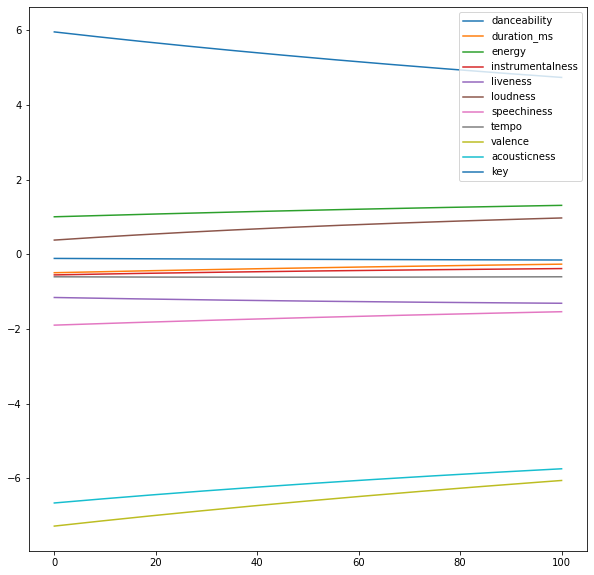

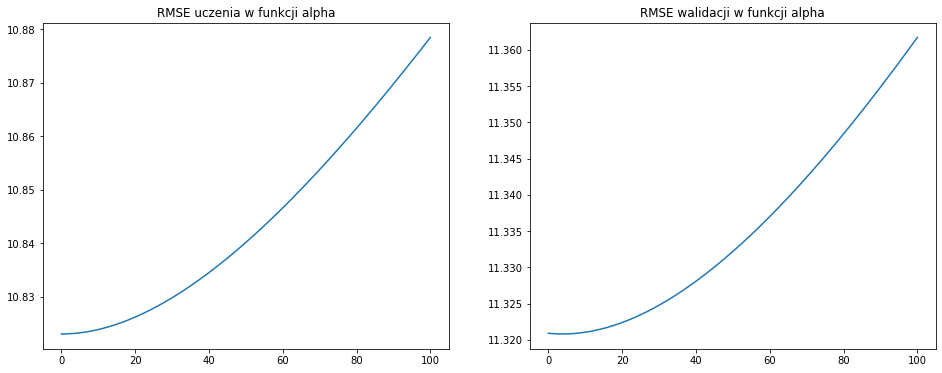

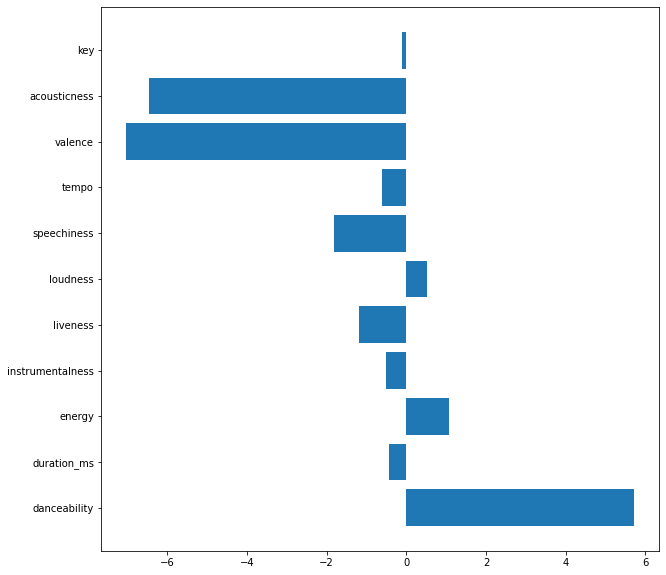

In [454]:
rmse_array_train = [None] * 1000
rmse_array_test = [None] * 1000

coef = [[0] * 11] * 1000

alpha_array = np.linspace(0, 100, 1000)

count = 0
for i in alpha_array:
    model_all = linear_model.Ridge(alpha=i, normalize=False) # set parameters
    model_all.fit(x_train, y_train) # learn weights
    coef[count] = model_all.coef_
    y_pred = model_all.predict(x_train)                    
    mse = metrics.mean_squared_error(y_pred, y_train)
    rmse = math.sqrt(mse)
    rmse_array_train[count] = rmse
    
    y_pred = model_all.predict(x_test)                    
    mse = metrics.mean_squared_error(y_pred, y_test)
    rmse = math.sqrt(mse)
    rmse_array_test[count] = rmse
    
    count = count + 1
      
plt.figure(figsize = (10,10))
        
plt.plot(alpha_array, coef)
plt.legend(columns)
plt.show()    

fig, ax = plt.subplots(1,2, figsize = (16,6))


ax[0].plot(alpha_array, rmse_array_train)
ax[0].set_title("RMSE uczenia w funkcji alpha")

ax[1].plot(alpha_array, rmse_array_test)
ax[1].set_title("RMSE walidacji w funkcji alpha")

plt.figure(figsize = (10,10))
plt.barh(columns,coef[171])
plt.show()

Ponownie - brak zaskoczeń. Otrzymane wykresy są porównywalne z otrzymanymi w poprzednim podpunkcie. Nawet pomimo braku zerowania cech, ich istotność przedstawia się podobnie. Najważniejszymi cechami nadal są acousticness, valence oraz danceability. Energy oraz instrumentalness ponownie okazały się mniej istotne, co jedynie połowicznie potwierdza naszą hipotezę.

## Elastic Net

In [455]:
space_alpha = np.linspace(0,10, 100)
space_ratio = np.linspace(0,1, 20)
params_elastic = {'alpha': space_ridge, 'l1_ratio': space_ratio}

modelElastic = ElasticNet()
clfElastic = GridSearchCV(modelElastic, params_elastic)
clfElastic.fit(x_train, y_train)

print('Wartość alpha z najlepszym wynikiem:', clfElastic.best_params_)
y_pred_elastic = clfElastic.predict(x_train)
err_elastic = metrics.mean_squared_error(y_train, y_pred_elastic)
print('RMSE uczenia metody Elastic Net dla najlepszych parametrów:',err_elastic)
y_pred_elastic = clfElastic.predict(x_test)
err_elastic = metrics.mean_squared_error(y_test, y_pred_elastic)
print('RMSE generalizacji metody Elastic Net dla najlepszych parametrów:',err_elastic)

Wartość alpha z najlepszym wynikiem: {'alpha': 0.0, 'l1_ratio': 0.0}
RMSE uczenia metody Elastic Net dla najlepszych parametrów: 117.1382758432574
RMSE generalizacji metody Elastic Net dla najlepszych parametrów: 128.1630408071416


In [456]:
space_alpha = np.linspace(0,1, 100)
space_ratio = np.linspace(0,1, 10)
params_elastic = {'alpha': space_ridge, 'l1_ratio': space_ratio}

modelElastic = ElasticNet()
clfElastic = GridSearchCV(modelElastic, params_elastic)
clfElastic.fit(x_train[hybrid_columns], y_train)

print('Wartość alpha z najlepszym wynikiem:', clfElastic.best_params_)
y_pred_elastic = clfElastic.predict(x_train[hybrid_columns])
err_elastic = metrics.mean_squared_error(y_train, y_pred_elastic)
print('RMSE uczenia metody Elastic Net dla najlepszych parametrów:',err_elastic)
y_pred_elastic = clfElastic.predict(x_test[hybrid_columns])
err_elastic = metrics.mean_squared_error(y_test, y_pred_elastic)
print('RMSE generalizacji metody Elastic Net dla najlepszych parametrów:',err_elastic)

Wartość alpha z najlepszym wynikiem: {'alpha': 0.0, 'l1_ratio': 0.0}
RMSE uczenia metody Elastic Net dla najlepszych parametrów: 117.81447974606012
RMSE generalizacji metody Elastic Net dla najlepszych parametrów: 126.13023875640042


W obu przypadkach najlepszą wartością l1_ratio jest 0, co oznacza równowartość użycia regresji grzbietowej. Biorąc pod uwage wcześniejsze rozpatrzenie tej metody, zbędnym byłaby jej dalsza analiza.


## Wnioski

Badanie różnych metod regularyzacji, okazało się bardzo korzystne. Poza wiedzą zdobytą w trakcie przeprowadzania testów, każda z metod miała wpływ na ostateczny stan modelu. Pomimo tego, że regresja grzbietowa osiągnęła najlepsze wyniki, badanie modeli regresji Lasso pozwoliło nam na korzystniejszy wybór cech. Nawet metoda Elastic Net, która okazała się jedynie powtórzeniem badanie metody regresji grzbietowej, pomogła nam upewniając nas w doborze cech. W ostatecznym modelu znalazły się wszystkie cechy z naszej hipotezy oprócz energy, podczas badania regularyzacji dodane zostały cechy liveness, valence, speechiness.  Dokładność naszego modelu mogłaby zostać zwiększona przez większą liczbę rekordów, rozdzielenie każdego z gatunków na poszczególne utwory oraz dodatkowe cechy takie jak data powstania utworu czy kwota przeznaczona na marketing.